<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Experiments/Experiment_%5B2%5D_Geospatial_congestion_detection_chicago_bus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Below video describes the problem statement. Here we are trying to detect congestion in pubic networks (buses) for a particlular city. API to get vehicles location is already provided.

In [8]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/D3QxN_DYwFo?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Packages Installation

In [0]:
#Installing GeoPandas
!pip install geopandas

# Installing Cartopy
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!pip install contextily
!pip install more_itertools

**General Geo Pandas Interaction with Maps**

Crs Before: {'init': 'epsg:4326'}
Crs After: {'init': 'epsg:3857', 'no_defs': True}


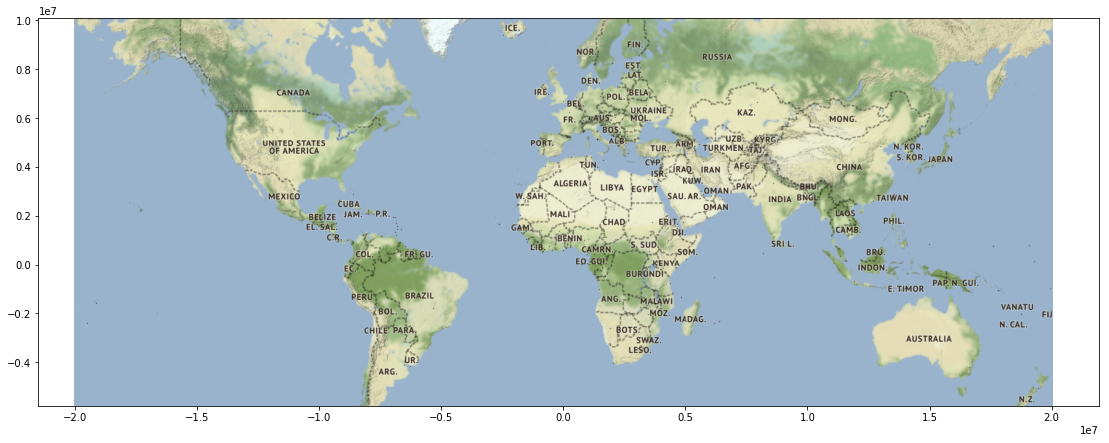

In [9]:
import geopandas as gpd
import contextily as ctx

world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
# world = world[world.name == 'New Delhi']
print("Crs Before:", world.crs)
world = world.to_crs(epsg=3857)
print("Crs After:", world.crs)

def add_basemap(ax, zoom, url):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis((xmin, xmax, ymin, ymax))
    
ax = world.plot(figsize=(19, 19), edgecolor='black', alpha=0.5, markersize=0.1)
add_basemap(ax, zoom=3, url=ctx.sources.ST_TERRAIN)

## Solution

CTA Bustracker Require API KEY in order to access their API, this key can be online acquired by registering


**API Documentation** - The document on how to interact with API can be found at below URL

 "https://www.transitchicago.com/assets/1/6/cta_Bus_Tracker_API_Developer_Guide_and_Documentation_20160929.pdf"

In [0]:
API_KEY = ""
# API key can make a maximum of 10,000 daily requests

**Routes**

Using below API we wil get all the routes list in which buses will travel

In [10]:
import requests
import json

params = "format=json&key=%s" % (API_KEY)
resp = requests.get("http://www.ctabustracker.com/bustime/api/v2/getroutes?" + params)
json.loads(resp._content)

routes = [x['rt'] for x in json.loads(resp._content)['bustime-response']['routes']]
print("Total Routes:", len(routes))
print("Example Routes:", routes[0:10])

Total Routes: 126
Example Routes: ['1', '2', '3', '4', '5', '6', '7', '8', '8A', '9']


**Directions**

Listing All the directions in which buses will travel

In [11]:
directions_all = []
for cntr, route in enumerate(routes):
  resp = requests.get("http://www.ctabustracker.com/bustime/api/v2/getdirections?" + params + "&rt=" + route)
  json.loads(resp._content)
  directions = [x['dir'] for x in json.loads(resp._content)['bustime-response']['directions']]
  directions_all.extend(directions)
  directions_all = list(set(directions_all))

print("Total Directions:", len(directions_all))
print(directions_all)

Total Directions: 4
['Southbound', 'Eastbound', 'Westbound', 'Northbound']


**Stops**

Checking Availaible Stops, we will be using the lat and lon information provided here

In [12]:
import pandas as pd
stops_all = []
for cntr, route in enumerate(routes): 
  for direction in directions_all:
    try:
      resp = requests.get("http://www.ctabustracker.com/bustime/api/v2/getstops?" + params+ "&rt=" + route + "&dir=" + direction)
      stops = [x for x in json.loads(resp._content)['bustime-response']['stops']]
      stops_all.extend(stops)
    except Exception as err:
      pass

print("Total Stops (including dups):", len(stops_all))
stops_all = list(pd.DataFrame(stops_all).drop_duplicates(['stpid']).T.to_dict().values())

print("Total Stops:", len(stops_all))
stops_all = list(pd.DataFrame(stops_all).drop_duplicates(['stpnm']).T.to_dict().values())
print("Total Stops:", len(stops_all))

print("Example Stops:", stops_all[0:2])

Total Stops (including dups): 14367
Total Stops: 10779
Total Stops: 6803
Example Stops: [{'lat': 41.878105999999, 'lon': -87.632957999999, 'stpid': '69', 'stpnm': 'JACKSON + FINANCIAL PLACE'}, {'lat': 41.878079999999, 'lon': -87.635448999999, 'stpid': '68', 'stpnm': 'JACKSON + FRANKLIN'}]


In [13]:
min_lat, max_lat = min(x['lat'] for x in stops_all), max(x['lat'] for x in stops_all)
min_lon, max_lon = min(x['lon'] for x in stops_all), max(x['lon'] for x in stops_all)
min_lat, max_lat, min_lon, max_lon, len(stops_all)

(41.644792999999, 42.064536999999, -87.884768000001, -87.525582999999, 6803)

**Plot the Stops information on GeoMap**

Below we will plot all sampled stop information on Map. Green dots are stops.

(6803, 4)


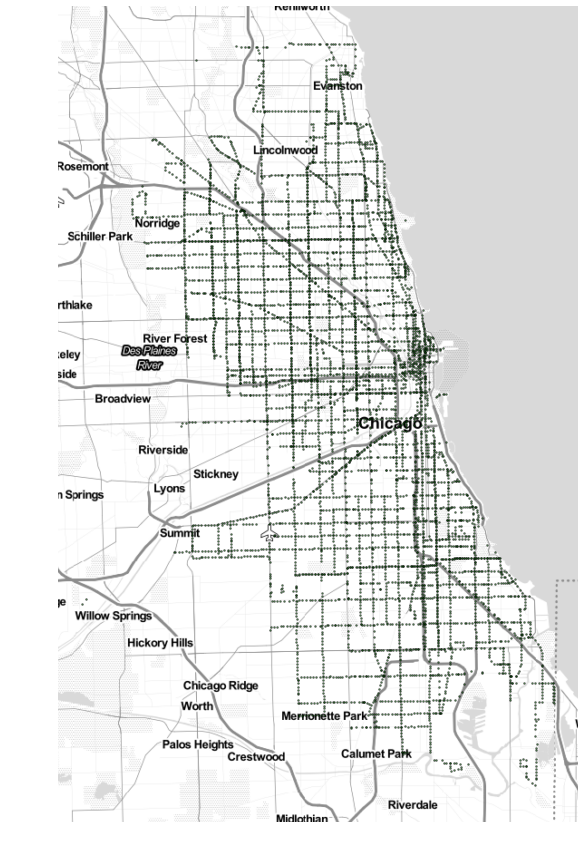

In [14]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import random

def add_basemap(ax, zoom, url):
  # Plot The information on terrain
  xmin, xmax, ymin, ymax = ax.axis()
  basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
  ax.imshow(basemap, extent=extent, interpolation='bilinear')
  ax.axis((xmin, xmax, ymin, ymax))


# df = pd.DataFrame(random.sample(stops_all, 3000))
df = pd.DataFrame(stops_all)

print(df.shape)
# Create a GeoDataFrame Obj from Lat & Lon and initialize epsg as 4326 identifier for Lat and Long
gdf = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326', 'no_defs': True}, geometry=gpd.points_from_xy(df.lon, df.lat))

# Convert The CRS to format which our Terrain map can understand
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(15, 15), c='green', edgecolor='black', alpha=0.5, marker='.', markersize=10)
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()


**Vechicles**

Quering the API to get Buses location at present time.

In [16]:
vehicles_all = []
from more_itertools import chunked

routes_chunks = chunked(routes, 10)
# print("Total Chunks:", len(list(routes_chunks)))

for cntr, route_chunk in enumerate(routes_chunks):
  route = ",".join(route_chunk)
  resp = requests.get("http://www.ctabustracker.com/bustime/api/v2/getvehicles?" + params + "&rt=" + route)
  vehicles = [x for x in json.loads(resp._content)['bustime-response']['vehicle']]
  vehicles_all.extend(vehicles)

print("Total Vehicles (including dups):", len(vehicles_all))
vehicles_all = list(pd.DataFrame(vehicles_all).drop_duplicates(['vid']).T.to_dict().values())
print("Total Vehicles:", len(vehicles_all))
print("Example Vehicles:", vehicles_all[0:2])

Total Vehicles (including dups): 804
Total Vehicles: 804
Example Vehicles: [{'des': 'Michigan/Chicago', 'dly': False, 'hdg': '359', 'lat': '41.72900688864968', 'lon': '-87.61428833007812', 'pdist': 4494, 'pid': 5342, 'rt': '3', 'tablockid': '3 -751', 'tatripid': '1006997', 'tmstmp': '20190831 15:57', 'vid': '1233', 'zone': ''}, {'des': 'Michigan/Chicago', 'dly': False, 'hdg': '356', 'lat': '41.78932812339381', 'lon': '-87.61578931306538', 'pdist': 26708, 'pid': 5342, 'rt': '3', 'tablockid': '3 -720', 'tatripid': '1006994', 'tmstmp': '20190831 15:57', 'vid': '1294', 'zone': ''}]


**Plot the Vehicles information on GeoMap**

Below we will plot all the vehicle  and sampled stop information on Map. Blue dots are Vehcles/Buses. Blue dots are stops

(6803, 5)


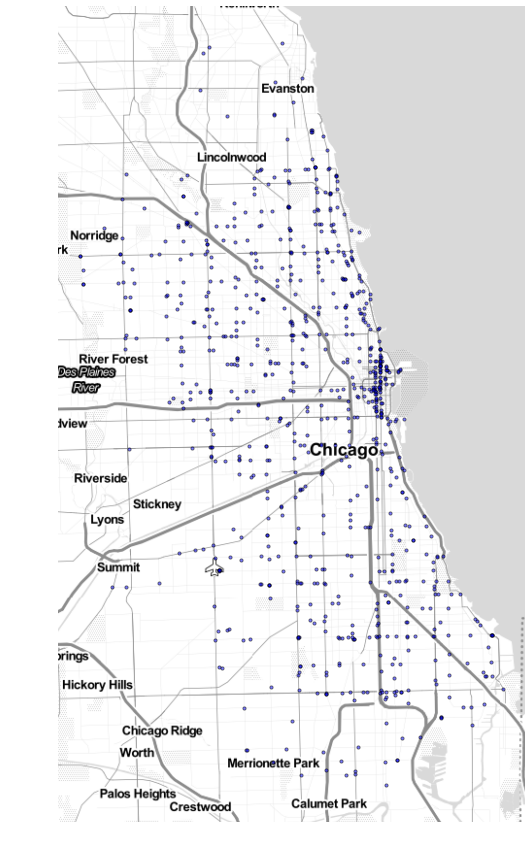

In [18]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import random
import matplotlib.pyplot as plt

def add_basemap(ax, zoom, url):
  # Plot The information on terrain
  xmin, xmax, ymin, ymax = ax.axis()
  basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
  ax.imshow(basemap, extent=extent, interpolation='bilinear')
  ax.axis((xmin, xmax, ymin, ymax))

fig, ax = plt.subplots(figsize=(15, 15))

# '''Plotting Stops'''
# df_stop = pd.DataFrame(random.sample(stops_all, 1000))
# print(df.shape)
# gdf = gpd.GeoDataFrame(df_stop, crs={'init' :'epsg:4326', 'no_defs': True}, geometry=gpd.points_from_xy(df_stop.lon, df_stop.lat))
# gdf = gdf.to_crs(epsg=3857)
# gdf.plot(ax=ax, c='green', edgecolor='black', alpha=0.5, marker='s', markersize=5)

'''Plotting Vehicles'''
df_vehicle = pd.DataFrame(vehicles_all)
df_vehicle['lon'] = df_vehicle['lon'].astype(float)
df_vehicle['lat'] = df_vehicle['lat'].astype(float)
print(df.shape)
gdf = gpd.GeoDataFrame(df_vehicle, crs={'init' :'epsg:4326', 'no_defs': True}, geometry=gpd.points_from_xy(df_vehicle.lon, df_vehicle.lat))
gdf = gdf.to_crs(epsg=3857)
gdf.plot(ax=ax, c='blue', edgecolor='black', alpha=0.5, marker='o', markersize=10)

add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()

### Detecting Congestion

Below we will be using DBScan algorithm to detect congestion based on lat and lon as our input features. 

Now their are 2 parameters we need to provide.

**1. Min Vehicles to be present near each other, in order to considered them as clustered - 4 (Choosen)**

**2. Max Distance B/W vehicles** -  This is crucial and has a tradeoff 
* **Small  Value** - Means veichles should be really close in order to be said them to be in cluster.
* **Large Value** - Will Consider Vehicles really far to be as part of cluster. 

We only need to choose them once as Lat and Lon are standard entities so whatever distance we choose is always valid regardless of what time and state.



### Plotting 

For ploting we are using following colors as identifier.







*  **Blue** : Vechicles are freely moving and are not in any traffic
*  **Yellow** : Vehicles are in light traffic
*  **Red** : 10 or more vehciles are near each other, hence we classify it as heavy traffic.



Total clusters: 25
-1 (638, 15) no_traffic
0 (54, 15) heavy_traffic
1 (6, 15) light_traffic
2 (7, 15) light_traffic
3 (4, 15) light_traffic
4 (5, 15) light_traffic
5 (6, 15) light_traffic
6 (4, 15) light_traffic
7 (4, 15) light_traffic
8 (4, 15) light_traffic
9 (8, 15) light_traffic
10 (4, 15) light_traffic
11 (4, 15) light_traffic
12 (7, 15) light_traffic
13 (4, 15) light_traffic
14 (5, 15) light_traffic
15 (4, 15) light_traffic
16 (4, 15) light_traffic
17 (4, 15) light_traffic
18 (4, 15) light_traffic
19 (6, 15) light_traffic
20 (6, 15) light_traffic
21 (4, 15) light_traffic
22 (4, 15) light_traffic
23 (4, 15) light_traffic


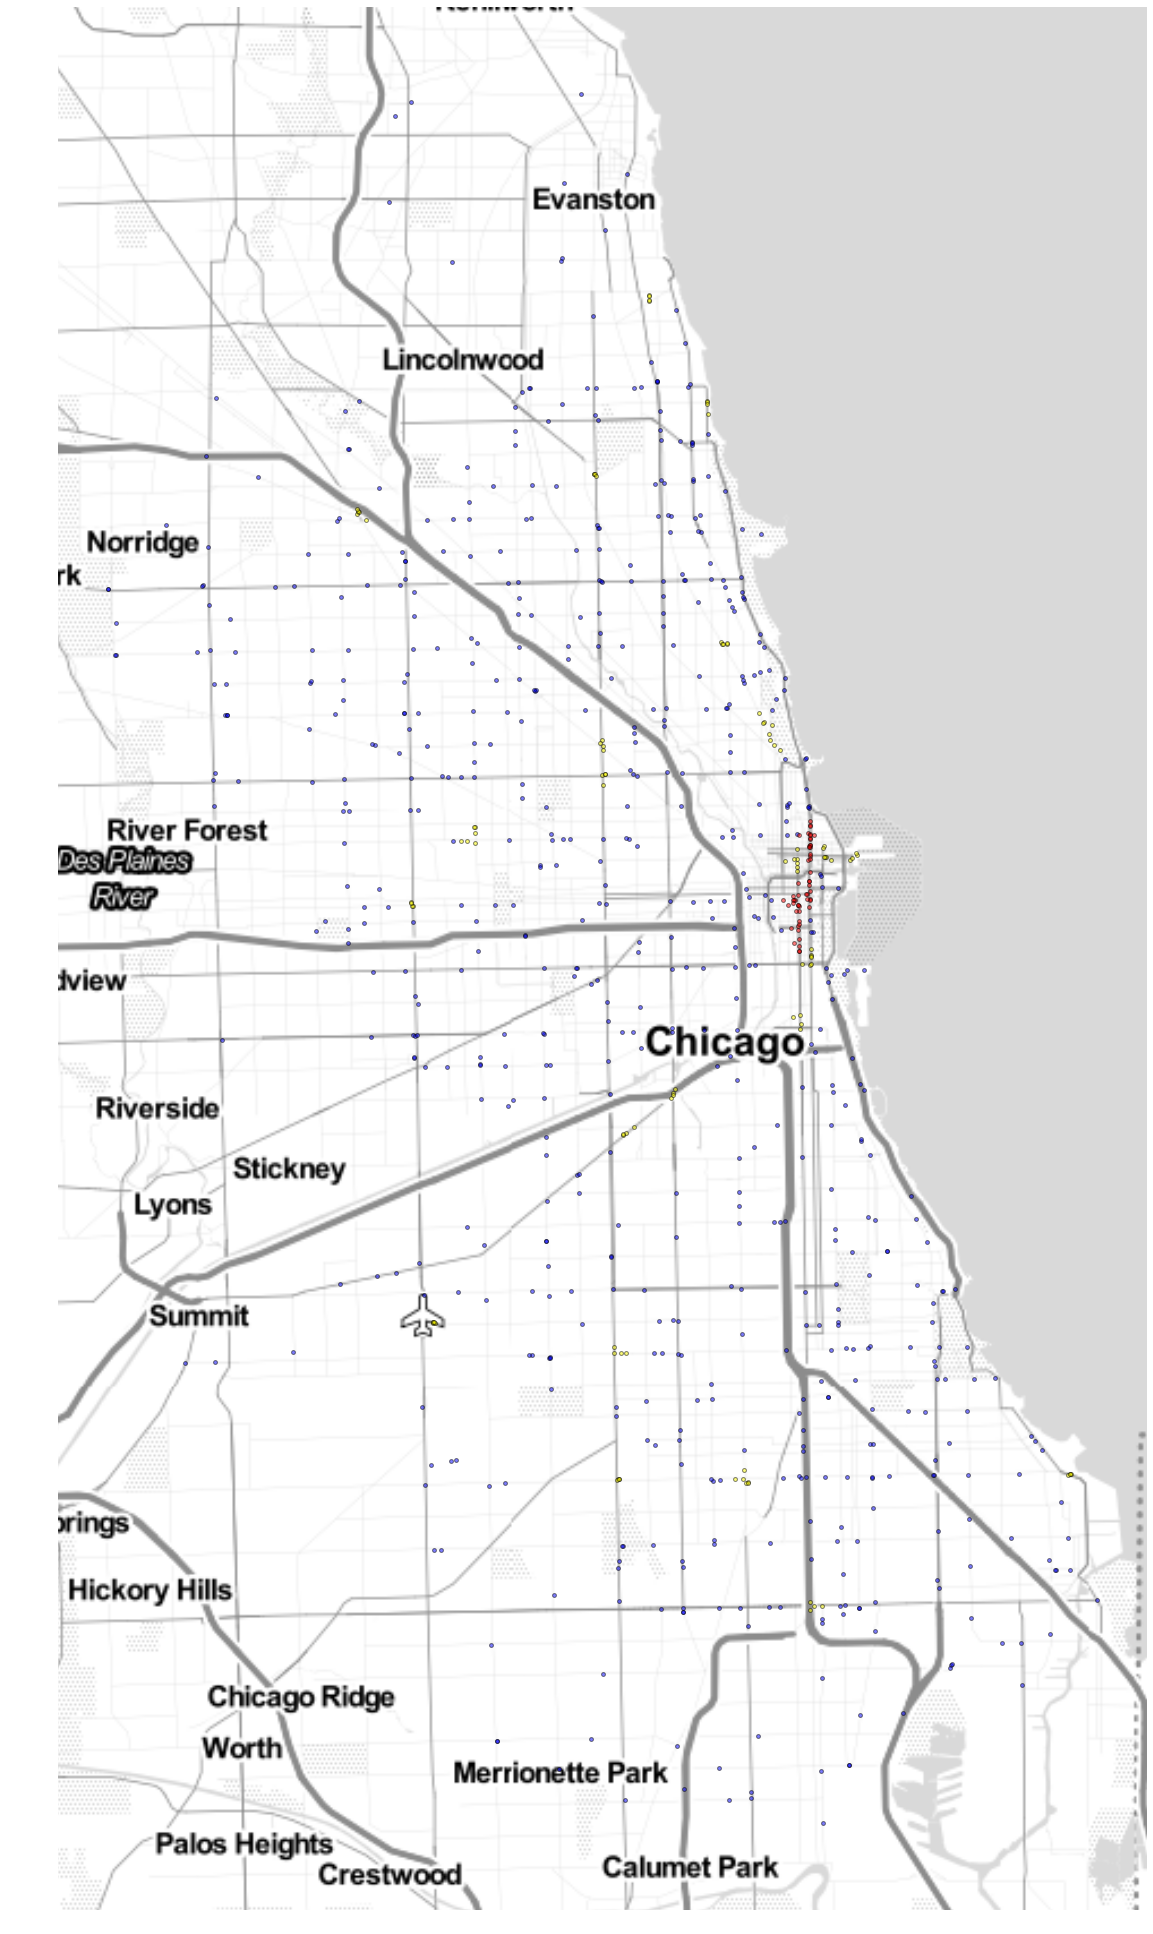

In [19]:
from sklearn.cluster import DBSCAN
from scipy import stats
import numpy as np

df_vehicle = pd.DataFrame(vehicles_all)
df_vehicle['lon'] = df_vehicle['lon'].astype(float)
df_vehicle['lat'] = df_vehicle['lat'].astype(float)

X = df_vehicle[['lat', 'lon']]
clustering = DBSCAN(eps=0.003, min_samples=4).fit(X)
df_vehicle['cluster_id'] = clustering.labels_

fig, ax = plt.subplots(figsize=(35, 35))
print("Total clusters:", len(np.unique(clustering.labels_)))
for cluster_id in np.unique(clustering.labels_):
  c_df = df_vehicle[df_vehicle['cluster_id'] == cluster_id]
  gdf = gpd.GeoDataFrame(c_df, crs={'init' :'epsg:4326', 'no_defs': True}, geometry=gpd.points_from_xy(c_df.lon, c_df.lat))
  gdf = gdf.to_crs(epsg=3857)
  
  colors = {'no_traffic': "blue", 'light_traffic': "yellow", 'heavy_traffic': "red"}
#   markers = {'no_traffic': "o", 'light_traffic': "p", 'heavy_traffic': "X"}
  markers = {'no_traffic': "o", 'light_traffic': "o", 'heavy_traffic': "o"}

  traffic = "light_traffic"
  if cluster_id == -1:  
    traffic = "no_traffic"
  elif c_df.shape[0] >= 10:
    traffic = "heavy_traffic"
  print(cluster_id, c_df.shape, traffic)

  gdf.plot(ax=ax, c=colors[traffic], edgecolor='black', alpha=0.5, marker=markers[traffic], markersize=15)
  
# '''Plotting Stops (Optional)'''
# df_stops = pd.DataFrame(stops_all)
# gdf = gpd.GeoDataFrame(df_stops, crs={'init' :'epsg:4326', 'no_defs': True}, geometry=gpd.points_from_xy(df_stops.lon, df_stops.lat))
# gdf = gdf.to_crs(epsg=3857)
# gdf.plot(ax=ax, c='green', edgecolor='black', alpha=0.5, marker="s", markersize=20)


add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax.set_axis_off()
# stats.itemfreq(clustering.labels_)